In [567]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import islice

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers.embeddings import Embedding
from keras.layers.core import Dropout, Dense
from keras.layers import Input, TimeDistributed, LSTM, Bidirectional, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras_lr_finder import LRFinder

In [385]:
PATH_DATA = '../data/data/'
PATH_MODELS = '../../models/'
PATH_IMAGES = '../assets/images/'
PATH_EMBED = '../../'
PATH_RESULTS = '../results/'

In [372]:
train = pd.read_csv(PATH_DATA+'CRC_3200_train.csv')
test = pd.read_csv(PATH_DATA+'CRC_800_test.csv')
c3 = pd.read_csv(PATH_DATA+'C3_12000.csv')
ynacc = pd.read_csv(PATH_DATA+'YNACC.csv')

In [588]:
# training set
X_train = np.asarray(train.text_review)
y_train = to_categorical(train.tag)

# test set
X_test = np.asarray(test.text_review)
y_test = to_categorical(test.tag)

X_test_c3 = np.asarray(c3.text_review)
y_test_c3 = np.asarray(c3.bin_tag)

X_test_ynacc = np.asarray(ynacc.text_review)
y_test_ynacc = np.asarray(ynacc.bin_tag)

Determining the maximum length of inputs.

In [518]:
print(train.num_tokens.describe(percentiles=[.25, .5, .75, .9, .99]))

count    3200.000000
mean       62.586250
std       118.035125
min         1.000000
25%        13.000000
50%        29.000000
75%        66.000000
90%       136.000000
99%       523.010000
max      2865.000000
Name: num_tokens, dtype: float64


150 seems like a good value

In [118]:
MAXLEN = 150

tokenizer = Tokenizer(num_words=20000, filters='', lower=True, char_level=False)

tokenizer.fit_on_texts(X_train)

X_train_tok = tokenizer.texts_to_sequences(X_train)
X_test_tok = tokenizer.texts_to_sequences(X_test)

VOCAB_SIZE = len(tokenizer.word_index) + 1

X_train_final = pad_sequences(X_train_tok, maxlen=MAXLEN, padding='post', truncating='post')
X_test_final = pad_sequences(X_test_tok, maxlen=MAXLEN, padding='post', truncating='post')

## Loading and mapping GloVe embeddings

In [199]:
glove = PATH_EMBED + 'glove.twitter.27B.200d.txt'

def load_words(embd_filepath):
    embd_dict = dict()
    with open(embd_filepath, encoding="utf8") as emb_file:
        for line in islice(emb_file, 1, None):
            records = line.split(' ')
            word = records[0]
            vector = np.asarray(records[1:], dtype='float32')            
            embd_dict[word] = vector
    return embd_dict

embd_dict = load_words(glove)

In [200]:
word_embedding = np.zeros((VOCAB_SIZE, 200))

for word, index in tokenizer.word_index.items():
    embedding_vector = embd_dict.get(word)
    if embedding_vector is not None:
        word_embedding[index] = embedding_vector

In [519]:
rate = (np.count_nonzero(np.count_nonzero(word_embedding, axis=1)) / VOCAB_SIZE) * 100
print(str(rate) + "%", "of the vocabulary was found in the pre-trained embedding.")

82.83789139912803% of the vocabulary was found in the pre-trained embedding.


## Model building

In [529]:
def make_model(vocab_size, maxlen, embeddings):
    
    #input
    input_layer = Input(shape=(None,), name='Input')
    
    #embedding
    embedding_layer = Embedding(vocab_size, 200, weights=[embeddings],
                            input_length=maxlen, trainable=True)(input_layer)
    
    #LSTM
    rnn_layer = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)
    rnn_layer = Bidirectional(LSTM(64, return_sequences=False))(rnn_layer)
    
    
    #dropout
    dropout_layer = Dropout(0.1)(rnn_layer)
    
    #softmax
    output_layer = Dense(4, activation='softmax')(dropout_layer)
    
    return Model(inputs=input_layer, outputs=output_layer)

In [553]:
model = make_model(VOCAB_SIZE, MAXLEN, word_embedding)

In [554]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              weighted_metrics=['categorical_accuracy'],
             )

In [555]:
lr_finder = LRFinder(model)
lr_finder.find(X_train_final, y_train, 0.00001, 0.1, 64, 1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
3200/3200 [==============================] - 22s 7ms/step - loss: 1.2442 - categorical_accuracy: 0.4275


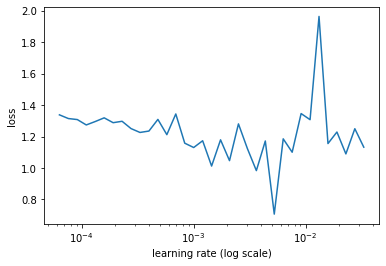

In [556]:
lr_finder.plot_loss()

In [557]:
hyperparameters = {
    'lr': 0.005,
    'epochs': 6,
    'batch_size': 64,
    'validation_size': 0.1,
}

In [558]:
#early stopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=1, mode='min', verbose=1)

#model checkpoints
checkpoints = ModelCheckpoint(PATH_MODELS+'best.multi.bilstm2.weights.hdf5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

#class weights
weights = class_weight.compute_class_weight('balanced', np.unique(test.tag), test.tag)
class_weights = dict(enumerate(weights))

In [559]:
history = model.fit(X_train_final,
                    y_train, 
                    batch_size=hyperparameters['batch_size'],
                    epochs=hyperparameters['epochs'],
                    validation_split=hyperparameters['validation_size'],
                    callbacks=[early_stop, checkpoints],
                    class_weight=class_weights,
                    verbose=1,
                   )

Train on 2880 samples, validate on 320 samples
Epoch 1/6
2880/2880 [==============================] - 20s 7ms/step - loss: 1.1895 - categorical_accuracy: 0.4682 - val_loss: 0.9851 - val_categorical_accuracy: 0.5908

Epoch 00001: val_loss improved from inf to 0.98511, saving model to ../../models/best.multi.bilstm2.weights.hdf5
Epoch 2/6
2880/2880 [==============================] - 20s 7ms/step - loss: 0.8605 - categorical_accuracy: 0.6358 - val_loss: 0.8374 - val_categorical_accuracy: 0.6639

Epoch 00002: val_loss improved from 0.98511 to 0.83744, saving model to ../../models/best.multi.bilstm2.weights.hdf5
Epoch 3/6
2880/2880 [==============================] - 21s 7ms/step - loss: 0.7497 - categorical_accuracy: 0.7056 - val_loss: 0.7952 - val_categorical_accuracy: 0.6662

Epoch 00003: val_loss improved from 0.83744 to 0.79515, saving model to ../../models/best.multi.bilstm2.weights.hdf5
Epoch 4/6
2880/2880 [==============================] - 20s 7ms/step - loss: 0.5956 - categorical_ac

## Ploting

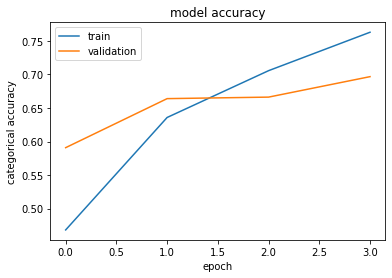

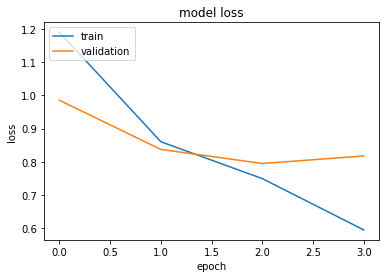

In [560]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])

plt.title('model accuracy')
plt.ylabel('categorical accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc = 'upper left')
plt.show()

### Saving model

In [564]:
model.save(PATH_MODELS+'multi-bilstm.h5')

### Loading model

In [581]:
model = load_model(PATH_MODELS+'multi-bilstm.h5')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Testing

In [570]:
def prep_test(data, tokenizer, maxlen):
    data = [str(x) for x in data]
    data_tok = tokenizer.texts_to_sequences(data)
    data_fin = pad_sequences(data_tok, maxlen=maxlen, padding='post', truncating='post')
    return data_fin

X_test_c3_final = prep_test(X_test_c3, tokenizer, MAXLEN)
X_test_ynacc_final = prep_test(X_test_ynacc, tokenizer, MAXLEN)

Accuracy: 0.655
F1 Score: 0.6414601627604921
              precision    recall  f1-score   support

           0       0.52      0.60      0.56       108
           1       0.71      0.71      0.71       280
           2       0.74      0.56      0.64       300
           3       0.55      0.83      0.66       112

    accuracy                           0.66       800
   macro avg       0.63      0.67      0.64       800
weighted avg       0.67      0.66      0.66       800



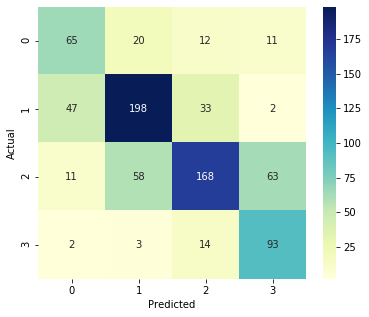

In [590]:
y_pred = model.predict(X_test_final)
#y_scores = np.asarray([1 if x > 0.5 else 0 for x in y_pred]) # binary classification only
y_gold = [np.argmax(i) for i in y_test]
y_scores = [np.argmax(i) for i in y_pred]
#y_gold = y_test # binary classification only

print("Accuracy:", accuracy_score(y_gold, y_scores))
print("F1 Score:", f1_score(y_gold, y_scores, average='macro'))
print(classification_report(y_gold, y_scores))
report = classification_report(y_gold, y_scores, output_dict=True)

conf_mat = confusion_matrix(y_gold, y_scores)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(conf_mat, cmap="YlGnBu", annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig(PATH_IMAGES+'multi-bilstm-CRC.png', bbox_inches='tight')
plt.show()

In [593]:
model.summary()

Model: "model_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_0 (InputLayer)         (None, None)              0         
_________________________________________________________________
layer_1 (Embedding)          (None, 150, 200)          3027600   
_________________________________________________________________
layer_2 (Bidirectional)      (None, 150, 128)          135680    
_________________________________________________________________
layer_3 (Bidirectional)      (None, 128)               98816     
_________________________________________________________________
layer_4 (Dropout)            (None, 128)               0         
_________________________________________________________________
layer_5 (Dense)              (None, 4)                 516       
Total params: 3,262,612
Trainable params: 3,262,612
Non-trainable params: 0
________________________________________________

In [562]:
pd.DataFrame(report).transpose().to_csv(PATH_RESULTS+'multi-bilstm-CRC.csv', index=False)

In [563]:
model.summary()

Model: "model_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, None)              0         
_________________________________________________________________
embedding_46 (Embedding)     (None, 150, 200)          3027600   
_________________________________________________________________
bidirectional_41 (Bidirectio (None, 150, 128)          135680    
_________________________________________________________________
bidirectional_42 (Bidirectio (None, 128)               98816     
_________________________________________________________________
dropout_39 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 4)                 516       
Total params: 3,262,612
Trainable params: 3,262,612
Non-trainable params: 0
________________________________________________